# [Loan Prediction](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/)

In [26]:
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

## Explore dataset

Read training set

In [2]:
train = pd.read_csv('train_ctrUa4K.csv')
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Drop Loan_ID column
#train.drop(columns=['Loan_ID'], inplace=True)

Read test set

In [4]:
test = pd.read_csv('test_lAUu6dG.csv')
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


Read sample submission

In [5]:
sample = pd.read_csv('sample_submission_49d68Cx.csv')
sample.head(2)

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N


Get info

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Loan_ID              367 non-null object
Gender               356 non-null object
Married              367 non-null object
Dependents           357 non-null object
Education            367 non-null object
Self_Employed        344 non-null object
ApplicantIncome      367 non-null int64
CoapplicantIncome    367 non-null int64
LoanAmount           362 non-null float64
Loan_Amount_Term     361 non-null float64
Credit_History       338 non-null float64
Property_Area        367 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


Count missing values

In [8]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [9]:
test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

There is no missing value in Education, ApplicantIncome, CoapplicantIncome, Property_Area columns.

Male      489
Female    112
NA         13
Name: Gender, dtype: int64


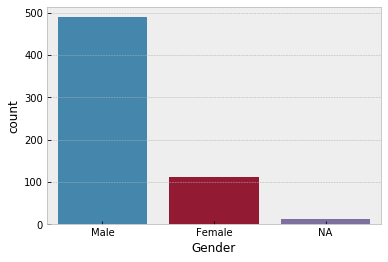

-------------------------
Yes    398
No     213
NA       3
Name: Married, dtype: int64


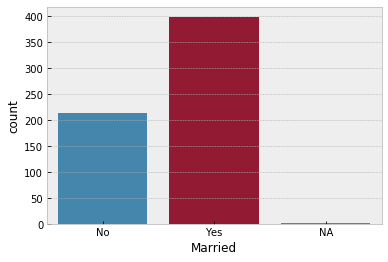

-------------------------
0     345
1     102
2     101
3+     51
NA     15
Name: Dependents, dtype: int64


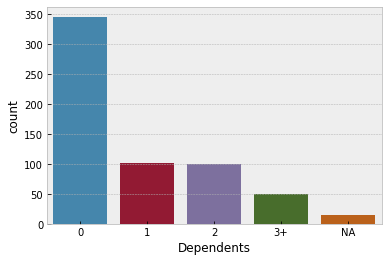

-------------------------
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


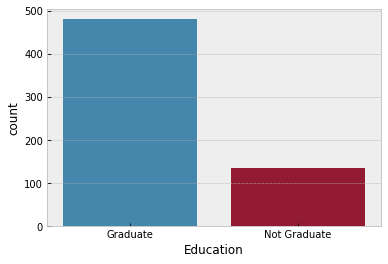

-------------------------
No     500
Yes     82
NA      32
Name: Self_Employed, dtype: int64


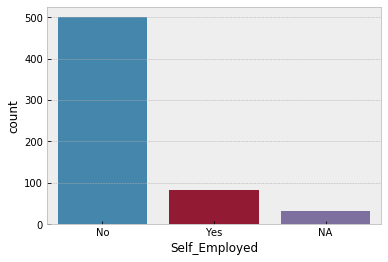

-------------------------
1.0    475
0.0     89
NA      50
Name: Credit_History, dtype: int64


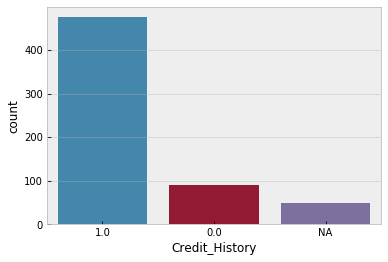

-------------------------
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


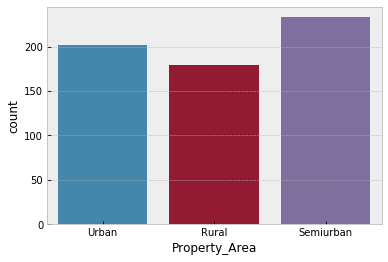

-------------------------
Y    422
N    192
Name: Loan_Status, dtype: int64


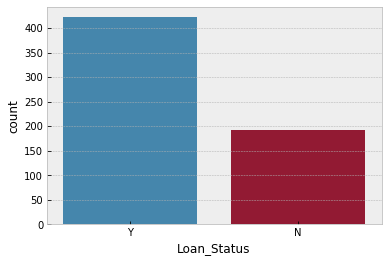

-------------------------


In [10]:
for col in ['Gender','Married','Dependents','Education',
            'Self_Employed','Credit_History','Property_Area','Loan_Status']:
    print(train[col].fillna('NA').value_counts())
    sns.countplot(x=col, data=train.fillna('NA'))
    plt.show()
    print('-'*25)

## Classify

Get features x and labels y

In [11]:
## Fill missing values
for col in ['ApplicantIncome', 'CoapplicantIncome',
            'LoanAmount', 'Loan_Amount_Term']:
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)
    
train['Credit_History'].fillna(2, inplace=True)
test['Credit_History'].fillna(2, inplace=True)

train.fillna('NA', inplace=True)
test.fillna('NA', inplace=True)

In [12]:
## Encode labels
for col in ['Gender','Married','Dependents','Education',
            'Self_Employed','Property_Area']:
    le = LabelEncoder().fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

le = LabelEncoder().fit(train['Loan_Status'])
train['Loan_Status'] = le.transform(train['Loan_Status'])
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,1,0,0,1,5849,0.0,0.0,360.0,1.0,2,1
1,LP001003,1,2,1,0,1,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1,2,0,0,2,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1,2,0,1,1,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1,1,0,0,1,6000,0.0,141.0,360.0,1.0,2,1


In [13]:
## Get training, validation, test
x = train.iloc[:, 1:12].to_numpy()
y = train['Loan_Status'].to_numpy()
x_test = test.iloc[:, 1:12].to_numpy()

# Scale 
scaler = StandardScaler().fit(x)
x = scaler.transform(x)
x_test = scaler.transform(x_test)

# split training & validation
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

### Linear SVC

Test accuracy: 0.777777777777778

In [14]:
linear_svc = LinearSVC().fit(x_train, y_train)

linear_svc_y_valid_pred = linear_svc.predict(x_valid)
linear_svc_acc = accuracy_score(y_valid, linear_svc_y_valid_pred)
print(classification_report(y_valid, linear_svc_y_valid_pred))

              precision    recall  f1-score   support

           0       0.91      0.45      0.61        44
           1       0.76      0.97      0.86        79

    accuracy                           0.79       123
   macro avg       0.84      0.71      0.73       123
weighted avg       0.81      0.79      0.77       123



In [15]:
linear_svc_output = pd.DataFrame({'Loan_ID':test['Loan_ID'].to_numpy(),
                         'Loan_Status':le.inverse_transform(linear_svc.predict(x_test))})
linear_svc_output.to_csv('linear_svc_output.csv', index=False)

### KNN

Test accuracy: 0.722222222222222

In [28]:
knn = KNeighborsClassifier().fit(x_train, y_train)

knn_y_valid_pred = knn.predict(x_valid)
knn_acc = accuracy_score(y_valid, knn_y_valid_pred)
print(classification_report(y_valid, knn_y_valid_pred))

              precision    recall  f1-score   support

           0       0.89      0.36      0.52        44
           1       0.73      0.97      0.84        79

    accuracy                           0.76       123
   macro avg       0.81      0.67      0.68       123
weighted avg       0.79      0.76      0.72       123



In [19]:
## Grid Search
parameters = {'n_neighbors':range(3,15,2),
             'weights':['uniform','distance'],
             'algorithm':['ball_tree','kd_tree','brute'],
             'p':[1,2,3]}
model = GridSearchCV(KNeighborsClassifier(), param_grid=parameters)
model.fit(x_train,y_train)
print('Best Score: ', model.best_score_)
print('Best Params: ', model.best_params_)

Best Score:  0.7718940936863544
Best Params:  {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 3, 'weights': 'distance'}


In [27]:
knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9,p=3, 
                           weights='distance').fit(x_train, y_train)

knn_y_valid_pred = knn.predict(x_valid)
knn_acc = accuracy_score(y_valid, knn_y_valid_pred)
print(classification_report(y_valid, knn_y_valid_pred))

              precision    recall  f1-score   support

           0       0.84      0.36      0.51        44
           1       0.73      0.96      0.83        79

    accuracy                           0.75       123
   macro avg       0.79      0.66      0.67       123
weighted avg       0.77      0.75      0.72       123



In [23]:
knn_output = pd.DataFrame({'Loan_ID':test['Loan_ID'].to_numpy(),
                         'Loan_Status':le.inverse_transform(knn.predict(x_test))})
knn_output.to_csv('knn_output.csv', index=False)

### SVC

Test accuracy: 0.770833333333333

In [24]:
svc = SVC().fit(x_train, y_train)

svc_y_valid_pred = svc.predict(x_valid)
svc_acc = accuracy_score(y_valid, svc_y_valid_pred)
print(classification_report(y_valid, svc_y_valid_pred))

              precision    recall  f1-score   support

           0       0.90      0.43      0.58        44
           1       0.75      0.97      0.85        79

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.72       123
weighted avg       0.81      0.78      0.76       123



In [25]:
svc_output = pd.DataFrame({'Loan_ID':test['Loan_ID'].to_numpy(),
                         'Loan_Status':le.inverse_transform(svc.predict(x_test))})
svc_output.to_csv('svc_output.csv', index=False)

### Random Forest

Test accuracy: 

In [29]:
rf = RandomForestClassifier().fit(x_train, y_train)

rf_y_valid_pred = rf.predict(x_valid)
rf_acc = accuracy_score(y_valid, rf_y_valid_pred)
print(classification_report(y_valid, rf_y_valid_pred))

              precision    recall  f1-score   support

           0       0.60      0.48      0.53        44
           1       0.74      0.82      0.78        79

    accuracy                           0.70       123
   macro avg       0.67      0.65      0.66       123
weighted avg       0.69      0.70      0.69       123



In [30]:
rf_output = pd.DataFrame({'Loan_ID':test['Loan_ID'].to_numpy(),
                         'Loan_Status':le.inverse_transform(rf.predict(x_test))})
rf_output.to_csv('rf_output.csv', index=False)